# Example of data access to eLabFTW

pyelabdata is a module that enables simple data access (read/write) to ELN entries. So far, the following typical scenarios have been taken into account, as they may occur in lab courses in physics:
* Reading table data (data entered column by column) from the main text of the ELN entry.
* Reading csv, hdf5 or image files that have been saved in an ELN entry as an attachment
* Saving and reading values in Extra Fields in an ELN entry
* Upload local files to an ELN entry
* Upload image files of diagrams generated using matplotlib
* Upload numerical data as a csv file
* Saving and uploading the current Jupyter notebook

In [1]:
import pyelabdata as eln
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from PIL import Image
from io import BytesIO
from IPython.display import display
from dotenv import dotenv_values

### Connect to eLabFTW
First, we connect with the eLabFTW server via its URL and an API key.

In [2]:
# Read server URL and API key from the .env file
config = dotenv_values(".env")

In [3]:
eln.connect(config['API_HOST_URL'], config['API_KEY'])

### Open experiment
Now we open an experiment in eLabFTW using the experiment ID; all subsequent commands apply to this experiment, unless another experiment is explicitly specified using the parameter expid=xxx. The return contains a dictionary with the metadata of the experiment.

In [4]:
# In this example, we open experiment ID 123.
eln.open_experiment(123)

### Load table data from the main text of an ELN entry
Without further parameters, the first table in the main text is retrieved.

In [5]:
data = eln.get_table_data()
print(data)

{'U (V)': array([0., 1., 2., 3., 4., 5., 6., 7., 8.]), 'I (mA)': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])}


By default, the data output is a dictionary of the data columns, whereby the keys (names) of the columns are extracted from the first table row. Alternatively, a pandas.DataFrame can also be returned by specifying the parameter datatype='df'.

Example for the visualisation of the data:

Text(0, 0.5, 'I (mA)')

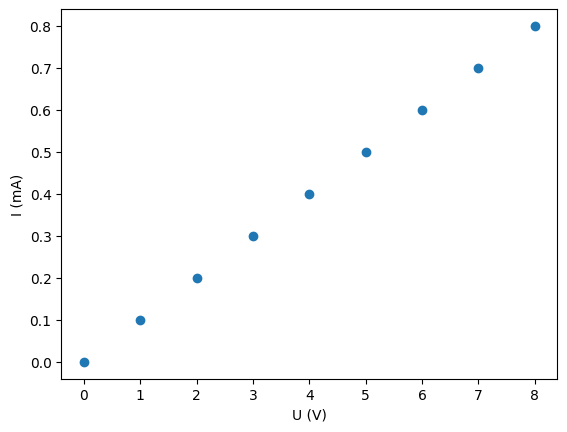

In [6]:
fig, ax = plt.subplots()
ax.scatter(data['U (V)'], data['I (mA)'])
ax.set_xlabel('U (V)')
ax.set_ylabel('I (mA)')

### Save data into an Extra Field in the ELN entry
We determine the ohmic resistance from the linear regression of the measurement data and save the result in the ELN entry into a new Extra Field "R" in the Extra Field group "Results".

In [7]:
result = linregress(data['U (V)'], data['I (mA)'])
R = 1 / result.slope * 1000
print(f'Resistance R = {R:.0f} Ohm')

Resistance R = 10000 Ohm


In [8]:
eln.create_extrafield('R', R, fieldtype='number', unit='Ohm', 
                      description='Electrical resistance obtained from a linear regression to the measurement data',
                      groupname='Results')

In [9]:
# The value of the Extra Field can be read again from the ELN, of course
value = eln.get_extrafields('R')
print(f'Value of the Extra Fields "R": {value}')

Value of the Extra Fields "R": 10000.0


### Load csv file from the ELN entry
For this, the file name is required. The return is similar as for get_table_data().

In [10]:
data = eln.get_file_csv_data('testdata.txt')
print(data)

{'t(s)': array([0., 1., 2., 3., 4., 5., 9.]), 'U(V)': array([1., 2., 4., 6., 7., 8., 8.])}


Text(0, 0.5, 'U (V)')

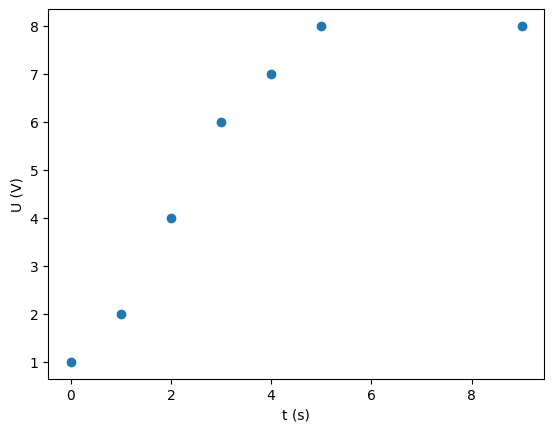

In [11]:
fig, ax = plt.subplots()
ax.scatter(data['t(s)'], data['U(V)'])
ax.set_xlabel('t (s)')
ax.set_ylabel('U (V)')

### Upload matplotlib diagrams to an ELN entry
The matplotlib figure object as well as a file name and a comment (description of the figure) are required for the upload.

Existing figures with the same file name are overwritten by default. Overwriting can be deactivated with the parameter replacefile=False; a new image attachment is then created with each upload.

In [12]:
eln.upload_image_from_figure(fig, 'testdata_plot.png', 'This is a diagram of the data contained in testdata.txt.')

### Load hdf5 file from the ELN entry
For this, the file name is required. The return value is a h5py file object as generated by the h5py.File.

In [13]:
hdf5file = eln.get_file_hdf5_data('data.nxs')

# hdf5 is a hierarchical file format. We list all keys at root level here.

keys = hdf5file.keys()
list(keys)

['Hacky_Hour_2024-03-18T12:47:11.810899+01:00']

In [14]:
# Let's load data from the first entry; those are stored in the section data/IV_sweep.
experiment = hdf5file[list(keys)[0]]
dataset = experiment['data/IV_sweep']

temperatures = np.unique(np.array(dataset['PID_setpoint']))
data = [
    {
        'setpoint': temp,
        'temperature_avg': np.average(dataset['PID_current_value'][np.where(dataset['PID_setpoint'] == temp)]),
        'voltage': np.array(dataset['SMU_mesV1'][np.where(dataset['PID_setpoint'] == temp)]),
        'current': np.array(dataset['SMU_mesI1'][np.where(dataset['PID_setpoint'] == temp)]),
    }
    for temp in temperatures
]
print(data)

[{'setpoint': np.float64(300.0), 'temperature_avg': np.float64(299.9997008898587), 'voltage': array([-10. ,  -9.9,  -9.8,  -9.7,  -9.6,  -9.5,  -9.4,  -9.3,  -9.2,
        -9.1,  -9. ,  -8.9,  -8.8,  -8.7,  -8.6,  -8.5,  -8.4,  -8.3,
        -8.2,  -8.1,  -8. ,  -7.9,  -7.8,  -7.7,  -7.6,  -7.5,  -7.4,
        -7.3,  -7.2,  -7.1,  -7. ,  -6.9,  -6.8,  -6.7,  -6.6,  -6.5,
        -6.4,  -6.3,  -6.2,  -6.1,  -6. ,  -5.9,  -5.8,  -5.7,  -5.6,
        -5.5,  -5.4,  -5.3,  -5.2,  -5.1,  -5. ,  -4.9,  -4.8,  -4.7,
        -4.6,  -4.5,  -4.4,  -4.3,  -4.2,  -4.1,  -4. ,  -3.9,  -3.8,
        -3.7,  -3.6,  -3.5,  -3.4,  -3.3,  -3.2,  -3.1,  -3. ,  -2.9,
        -2.8,  -2.7,  -2.6,  -2.5,  -2.4,  -2.3,  -2.2,  -2.1,  -2. ,
        -1.9,  -1.8,  -1.7,  -1.6,  -1.5,  -1.4,  -1.3,  -1.2,  -1.1,
        -1. ,  -0.9,  -0.8,  -0.7,  -0.6,  -0.5,  -0.4,  -0.3,  -0.2,
        -0.1,   0. ,   0.1,   0.2,   0.3,   0.4,   0.5,   0.6,   0.7,
         0.8,   0.9,   1. ,   1.1,   1.2,   1.3,   1.4,   1.5,   1

C:\Users\mpap00kp\AppData\Local\Temp\ipykernel_10020\108022969.py:5: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  temperatures = np.unique(np.array(dataset['PID_setpoint']))


### Read the (binary) content of a file from the ELN
In this example, we read an image file and display the image.

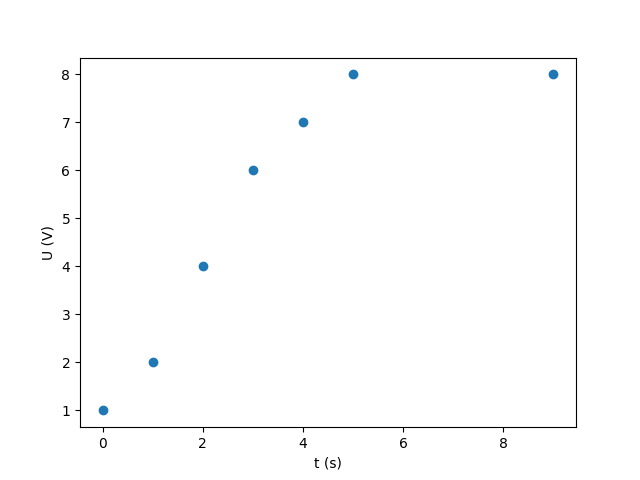

In [15]:
filedata = eln.get_file_data('testdata_plot.png')

# We use BytesIO to create a filestream from the binary data that can be read with Image.open.
display(Image.open(BytesIO(filedata)))

### Upload numerical data as a csv file to an ELN entry
The upload function can create a csv file from a DataFrame or a dictionary of column data (numpy arrays); in the latter case, the keys are used as column headers (see the following example).

In [16]:
# First, we generate a test signal (sine voltage with amplitude of 1 V and frequency of 4 Hz, 
# sampled at 101 points over 1 s).
t = np.linspace(0, 1, 101)
U = np.sin(2 * np.pi * 4 * t)

# Upload to eLabFTW
eln.upload_csv_data({'t (s)': t, 'U (V)': U}, 'voltage_sine.txt', 'A sine voltage with frequency of 4 Hz.')

### Save and upload this jupyter notebook to an ELN entry
To upload this Jupyter notebook to the ELN entry, all you need is a description.

In [17]:
eln.upload_this_jupyternotebook('This is the jupyter notebook that generated the evaluated data and uploads.')

### Disconnect from the eLabFTW server

In [18]:
eln.disconnect()